<h1 style="font-size:35px;color:black;">Greg Jensen: Lab 2 Digital Quantum Simulations</h1>
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In this tutorial, we will introduce time evolution of quantum states and how to simulate them using the Trotter-Suzuki formalism.  We then show to how to run the time evolution of a one dimensional Ising chain with three sites.

## Contents
1. [Introduction](#introduction)
2. [Trotter-Suzuki Formalism](#ts-equation)
3. [The Heisenberg Model](#heisenberg-equation)
4. [Trotterization](#trotterization)
5. [Qiskit Implementation](#qiskit)

## Introduction <a id='introduction'></a>

Classical simulation of physical systems typically begin by solving simple differential equations such as $\frac{dy}{dt} = f(y)$ which, to first order, has the solution $y(t+\Delta t)\approx y(t)+f(y)\Delta t$.  Meanwhile in quantum mechanics, we are concerned with the solution to $-i\hbar\frac{d\ket{\psi}}{dt}=H\ket{\psi}$, which for a time-indepent $H$, is
$$ \ket{\Psi(t)} = e^{-i\hbar Ht}\ket{\Psi(0)} $$

and the simulation of a quantum system requires the ability to perform the operation above.  

In most cases, this reduces to matrix exponentiation, but proves to be very difficult on classical computers due to the exponential growth of the size of the operator as the system size/Hilbert space increases.  A good attempt at a first order solution is $\ket{\psi(t+\Delta t)}\approx (I-i\hbar H\Delta t)\ket{\psi(t)}$, but this is generally not satisfactory.  However, if we can exponentiate the Hamiltonian, we only need a sufficiently small time step to simulate our system

$$ \ket{\psi(t+\Delta t)}= e^{-i\hbar H\Delta t}\ket{\psi(t)} $$

Efficient approximations to the solution of this equation are possible for Hamiltonians which carry local interactions between the system's consitutent subsystems.  These classes of Hamiltonians can be written in the form

$$ H = \sum_k^L H_k $$

where each $H_k$ acts locally on only a portion of the total system.  For example, the terms are often just two-body interactions (such as $X_iX_j$) and one-body Hamiltonians (such as $Z_i$).  For the physicists out there, both the Ising and Hubbard models (as we'll see later on) can be written in this way.  The advantage of writing the Hamiltonian in this way is that although the total time evolution operator $e^{iHt}$ may be difficult to compute, it is much easier to use $e^{iH_kt}$ as it acts on a much smaller subsytem and is straightforward to approximate using quantum circuits.

## Trotter-Suzuki Formalism <a id='ts-equation'></a>

Now armed with this idea of considering the Hamiltonian as a sum over a set of smaller subsystems, we can examine what our time evolution operator looks like.  It is important to note that because the subsystem terms $H_k$ do not generally commute with each other, we can anotssume the exponential of the full Hamiltonian is a product of each of the terms $H_k$ i.e.

$$e^{-i\hbar Ht}\neq \prod_k e^{-i\hbar H_kt}.$$

We can move past this by using the first order Trotter-Suzuki formula which asymptotically approximates the sum

$$
   e^{-iHt} = \lim_{n\rightarrow\infty} \left(\prod_l e^{-iH_lt/n} \right)^n.
$$

From now on we'll set $\hbar=1$ (sorry experimentalists!).  So although we cannot exponentiate this Hamiltonian exactly, we can approximate it arbitrarily well using slices of size $1/n$.  Errors aside, this is still advantageous since we are able to efficiently implement a "difficult" gate $U(t)=e^{-iHt}$ by breaking the original problem into smaller pieces $e^{-iH_lt/n}$ which require only a limited set of elementary gates.


It may also help to provide a bit of an intuitive picture of the ST decomposition.  In his original paper discussing universal quantum simulators, Lloyd (S. Lloyd, Science 273, 1073) gave this example on the Trotter-Suzuki formalism:

<blockquote> The method for performing the simulation is conceptually straightforward, if mathematically involved. The goal is to get the simulator from point A to point B along a particular route. But the simulator can only be driven in certain directions--the operations that can be applied experimentally are limited--so it is usually not possible to go from point A to point B directly. But by moving the simulator first a little bit in one direction, then a little bit in another, then a little bit in another, and so on, it is possible to move from A to B. A car can only be driven forward and backward--it cannot be driven sideways. But it is still possible to parallel park. The following construction demonstrates a quantum analog of a familiar classical fact: By going forward and backing up a sufficiently small distance a large enough number of times, it is possible to parallel park in a space only $\epsilon$ longer than the length of the care </blockquote>

## The Quantum Ising Model <a id='ising-equation'></a>

The Ising model with a transverse field has the form
$$
    H_{Ising} = J\sum_i(Z_iZ_{i+1} + gX_i)
$$
where $J$ is a dimensionless coupling constant and $g$ is a similarly dimensionless constant corresponding to the strength of a transverse magnetic field.

In this model, two of the observables that are interesting to consider are the energy $\langle H \rangle$ and magnetization $\langle \sigma_z \rangle$.  For isolated systems, the energy should be constant in time (at least in the limit of the uncertainty principle) and so we'll be mostly focused on the magnetization which is a bit more interesting here.

The time evolution operator $U(t)$ has the form

$$
    e^{-itH} = \exp\left(-it\left(J\sum_i(Z_iZ_{i+1} + gX_i)\right)\right)
$$



###  Exact Evolution for 3 Spins

To get started with some data we can compare our circuit results to.  It turns out Qiskit has a nice set of tools we can use to produce this called `opflow` (there is also a [tutorial](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html) on this module if you are so inclined).  The cells below will build the Hamiltonian and corresponding (exact) time evolution operator, then apply it onto an initial state $|101\rangle$ and measure its expectation value for several times.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# Import Qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z


In [56]:
# Returns matrix representation of the non-periodic Ising model for 3 spin-1/2 particles in a line
def H_ising(J: float, g: float):
    #Interactions (I is the identity matrix; X and Z are Pauli matrices; ^ is a tensor product; * multiplies a scalar)
    ZZs = (Z^Z^I) + (I^Z^Z)
    Xs = (X^I^I) + (I^X^I) + (I^I^X)
    
    H = -J*(ZZs + (g*Xs))
    return H

# Returns matrix representation of U_ising(t) for a given time t and a set of system parameters
def U_ising(t, J, g):
    #Compute the Ising Hamiltonian as above
    H = H_ising(J, g)
    # Return the exponential of -i*t multiplied by the 3 spin Ising Hamiltonian
    return (t * H).exp_i()


U =  e^(-i*-1.0 * ZZI
- 1.0 * IZZ
- 1.0 * XII
- 1.0 * IXI
- 1.0 * IIX)


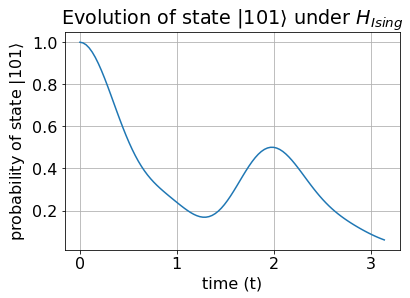

In [57]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)
J = 1.0
g = 1.

# Define initial state |101>
initial_state = One^Zero^One

#Test out U operator for time t=1.0
U = U_ising(1., J, g)
print("U = ",U)

# Compute probability of remaining in |101> state over the array of time points
 # The '~' gives the bra of the initial state (<101|)
 # @ is short hand for matrix multiplication
 # U_ising(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <101|U_ising(t)|101>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_101 = [np.abs((~initial_state @ U_ising(float(t), J, g) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |101>
plt.plot(ts, probs_101)
plt.xlabel('time (t)')
plt.ylabel(r'probability of state $|101\rangle$')
plt.title(r'Evolution of state $|101\rangle$ under $H_{Ising}$')
plt.grid()
plt.show()



### Measuring the Magnetization

Using opflow to measure the expectation of the total magnetization $\langle\sigma_z\rangle$ can similarly be written by adding in a couple functions which will compute $\langle\sigma_z\rangle$ in the computational basis.  In your last lab, you learned a bit about measuring expectation values and so here we will extend this by measuring over three qubits instead of just one.  Recall that the $Z$ operator has the form
$$
    Z = |0\rangle\langle0| - |1\rangle\langle1|
$$
and if we want to measure $Z$ for two qubits, we have a few choices: $IZ$, $ZI$, and $ZZ$
$$
    IZ = |00\rangle\langle00| - |01\rangle\langle01| + |10\rangle\langle10| - |11\rangle\langle11| \\
    ZI = |00\rangle\langle00| + |01\rangle\langle01| - |10\rangle\langle10| - |11\rangle\langle11| \\
    ZZ = |00\rangle\langle00| - |01\rangle\langle01| - |10\rangle\langle10| + |11\rangle\langle11|
$$
where you'll notice the first two operators are measuring $Z$ on *only* the first or second qubit while $ZZ$ measures on both.  To measure the magnetization we measure $Z$ on each of the qubits in our chain $\langle\sigma_z\rangle=IZ + ZI$

To extend this to a chain of *N* qubits, we can write the operator as:


$$    \langle\sigma_z\rangle = \frac{1}{N}\sum_i^{2^N}p_i\langle c_i|\sigma_z|c_i\rangle = \frac{1}{N}\sum_i^{2^N}p_i\left(n_i^0 - n_i^1\right) = \frac{1}{N}\sum_i^{2^N}p_i\left(N - 2n_i^1\right)    
$$

where $|c_i\rangle$ are each of the computational basis states, $p_i$ is the probability of measuring the *i*-th state and $n_i^0$, $n_i^1$ are the number of $0$'s and $1$'s in the bit string respectively.  



<h3 style="font-size: 20px">&#128211; Verify that this sum is equivalent to measuring: $\langle ZIII...I  + IZII...I + IIZ...I + ...  + III...IZ \rangle$

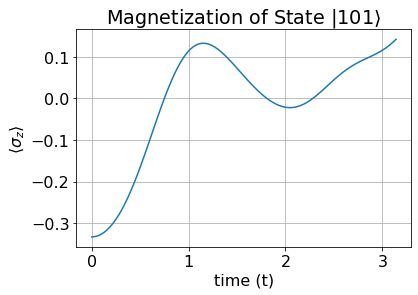

In [58]:
#Computational basis states for 3 qubits
states = [Zero^Zero^Zero, Zero^Zero^One, Zero^One^Zero, Zero^One^One, 
          One^Zero^Zero, One^Zero^One, One^One^Zero, One^One^One]

#Return the number of '1's in a given bit string
def bit_sum(n):
    sum = 0
    for bit in n:
        sum += int(bit)
    return sum

#Function to compute the magnetization from a given opflow state
def sigma_z(psi_t):
    state_probs = []
    for state in states:
        bit_string = list(state.primitive.keys())[0]
        bitsum = bit_sum(bit_string)
        state_probs.append((3.-2.*bitsum) * np.abs((~state @ psi_t).eval())**2)
    return sum(state_probs)/3
        
ts = np.linspace(0, np.pi, 100)

#Define your initial state
init_state = One^Zero^One

#Compute the magnetization at each time step
mags = [sigma_z(U_ising(float(t), J, g) @ init_state) for t in ts]

# Plot evolution of |110>
plt.plot(ts, mags)
plt.xlabel('time (t)')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title(r'Magnetization of State $|${}$\rangle$'.format(list(init_state.primitive.keys())[0]))
plt.grid()
plt.show()

## Trotterization <a id='trotterization'></a>
    
Now that we understand what about the Ising model we are interested in, let's take a look at what the time evolution operator $U(t)$ looks like as we "Trotterize" it.  If we assume a system of three sites and open boundary conditions, the Hamiltonian can be written as
$$
        H_{Ising} = J\sum_i(Z_iZ_{i+1} + gX_i) = JZ_0Z_1 + JZ_1Z_2 + JgX_0 + JgX_1 + JgX_2.
$$

We can then expand this out using the Trotter-Suzuki decomposition with $m$ slices
$$
       U(t) = \exp\left(-it\left(J\sum_i(Z_iZ_i{i+1} + gX_i)\right)\right) \\
           \approx \left[\prod_i \exp\left(-iH_i t/m\right)\right]^m \\
           = \left[e^{-it/mJ Z_0Z_1} e^{-it/mJ Z_1Z_2} e^{-it/mJgX_0} e^{-it/mJgX_1} e^{-it/mJgX_2}\right]^m \\
           = \left[e^{-i\theta_1 Z_0Z_1} e^{-i\theta_1 Z_1Z_2} e^{-i\theta_2X_0} e^{-i\theta_2X_1} e^{-i\theta_2X_2}\right]^m
$$

and are left with 5 exponential operators of the form either $ZZ(\theta)$ or $X(\theta)$.  These operators have matrix representations of:

$$
    ZZ(\theta) = \begin{pmatrix} e^{-i\frac{\theta}{2}} & 0 & 0 & 0 \\
                                0 & e^{i\frac{\theta}{2}} & 0 & 0 \\ 
                                0 & 0 & e^{i\frac{\theta}{2}} & 0 \\ 
                                0 & 0 & 0 & e^{-i\frac{\theta}{2}}  \end{pmatrix} \\ 
                                \\ 
    X(\theta) = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) & -i\sin\left(\frac{\theta}{2}\right) \\
                                i\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{pmatrix}
$$



<h3 style="font-size: 20px">&#128211; Expand each of the operators of U(t) and show that they are equivalent to the rotation matrices above.

## Qiskit Implementation <a id='qiskit'></a>

<h3 style="font-size: 20px">&#128211; Step A.  Build a circuit that will implement the operator $U(t)$ for a given target time and number of Trotter steps.

In [1]:
#### Your code goes here

#Conveniently enough, qiskit has both a ZZ(theta) and X(theta) gates by default. Check the docs on how to call them.
#Start by calculating the angle theta for a given time and number of steps. Then create function(s) to add on 

from qiskit import *
import numpy as np
from numpy import linalg as la
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter
import matplotlib.pyplot as plt #needed to draw circuits
import sys
print(sys.executable)

C:\Users\Greg Jensen\anaconda3\envs\qiskit\python.exe


In [2]:
#Define function to create theta and U(t)

def theta(t, m, J:float, g:float = 1.0): # theta sets g to 1 for ZZ operators and g to a passed value for the X operators
    return t*J*g/m

def U(t, m, J, g):
    # create a quantum circuit to append to the end of a 3 state circuit
    ugate = QuantumCircuit(3)#,3
    # set theta1 and theta2
    theta1=theta(t,m,J)
    theta2=theta(t,m,J,g)
    
    for n in range(m): # repeats the same gates m number of times
        # apply RZZ gates
        ugate.rzz(2*theta1,0,1)
        ugate.rzz(2*theta1,1,2)
        
        #apply RX gates
        ugate.rx(2*theta2,0)
        ugate.rx(2*theta2,1)
        ugate.rx(2*theta2,2)        

    return ugate

<h3 style="font-size: 20px">&#128211; Step B. Measure and plot the expectation of the state $|101\rangle$ as shown in section 3.1.  Plot this for several different numbers of Trotter steps to see how the trotterized $U(t)$ begins to converge to the true $U(t)$


With J= 1.0, g= 1.0, and t from 0.0 to 3.141592653589793:

For 1 Trotter steps:


        ┌───┐           ┌──────────┐             ░ ┌─┐      
   q_0: ┤ X ├─■─────────┤ Rx(2π/9) ├─────────────░─┤M├──────
        └───┘ │ZZ(2π/9) └──────────┘┌──────────┐ ░ └╥┘┌─┐   
   q_1: ──────■──────────■──────────┤ Rx(2π/9) ├─░──╫─┤M├───
        ┌───┐            │ZZ(2π/9)  ├──────────┤ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├────────────■──────────┤ Rx(2π/9) ├─░──╫──╫─┤M├
        └───┘                       └──────────┘ ░  ║  ║ └╥┘
meas: 3/════════════════════════════════════════════╩══╩══╩═
                                                    0  1  2 


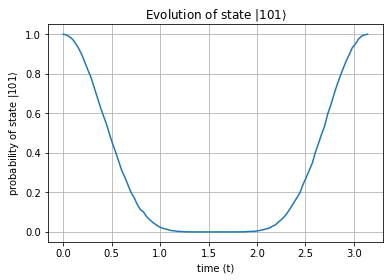


For 2 Trotter steps:




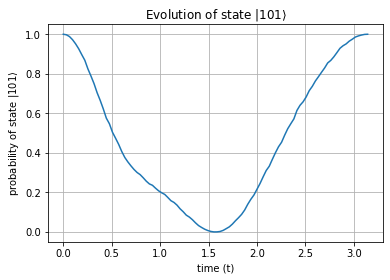


For 4 Trotter steps:




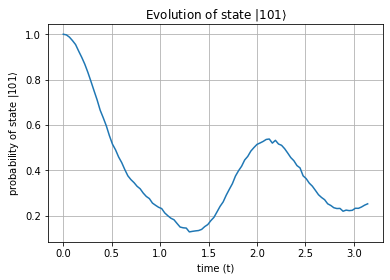


For 10 Trotter steps:




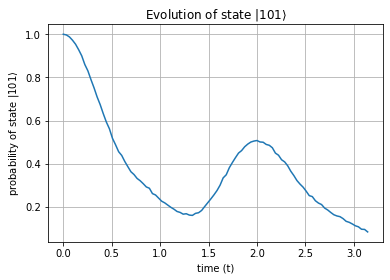

In [3]:
#### Your code goes here

#Note in the example plot, the parameters J = g = 1.0

#Recall that the results are returned as a dict object with the bitstring as keys and the number of counts as values.
# A suggestion to run this quickly is to use the Aer simulator backend.  For extra points, plot the time evolution
# using a real device

#### initialize parameters (J,g) and initialize quantum circuit states
J=g=1.0
istate=[1,0,1] #inital states given as list
ts = np.linspace(0,np.pi,100)

print(f"\nWith J= {J}, g= {g}, and t from {ts[0]} to {ts[-1]}:")

#initalize state given by list of initial states and putting an X gate on each state in list = 1
state_init = QuantumCircuit(len(istate))
for i in range(3):
    if istate[i]==1:
        state_init.x(i)
        

sim = Aer.get_backend('aer_simulator') #start AER simulator
shots = 2**14 # number of samples used for statistics

for m in [1,2,4,10]: # m=Trotter steps
    print("\nFor",m,"Trotter steps:\n\n")
    
    probs = {}#initalize dict for probs of each state
    for output in ['000','001','010','100','101','110','011','111']:
        probs[output]=[]
    
    for t in ts:
        
        # run the circuit and get the number of samples that output each bit value
        qc = state_init.compose(U(t,m,J,g))
        qc.measure_all()
        qc_trans = transpile(qc, sim)
        counts = sim.run(qc_trans, shots=shots).result().get_counts()
        
        if m==1 and t==0.3490658503988659:
            print(qc_trans)
            
        # calculate the probability for each computational basis
        for output in ['000','001','010','100','101','110','011','111']:
            if output in counts:
                probs[output].append(counts[output]/shots)
            else:
                probs[output].append(0)
            
    # Plot evolution of |101>
    plt.plot(ts, probs['101'])
    plt.xlabel('time (t)')
    plt.ylabel(r'probability of state $|101\rangle$')
    plt.title(r'Evolution of state $|101\rangle$')
    plt.grid()
    plt.show()

<h3 style="font-size: 17px">&#128211; Step C. Write a function to process the circuit results and calculate $\langle\sigma_z\rangle$.  Plot this against time as shown further above

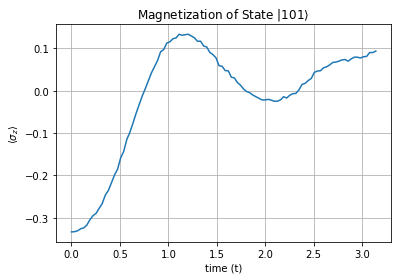

In [19]:
#### Your code goes here

#A helpful starting point here is to remember that the magnetization can be measured by examining each bitstring 
# from the results.



# Need to take the probability for |101> at each point 't' in the timescale 'ts', then multiply by the bitstring


#### initialize parameters (J,g) and initialize quantum circuit states
J=g=1.0
ts = np.linspace(0,np.pi,100)

#create function to return number of 1's in a given string of 1's and 0's
def n1(output):
    output_state=list(map(int,list(output))) # makes 'output' string into a list and maps the elements to ints

    n1=0
    for i in range(3): # initializes number of 1's to 0, then goes through previous list and sums the # of 1's
        if output_state[i]==1:
            n1 += 1
    return n1


def sigmaZ(probs,i): # the magnetization is calculated based on the bitstring and circuit results
    state_mags = []
    for output in ['000','001','010','100','101','110','011','111']:
        state_mags.append((3.-2.*n1(output)) * probs[output][i])
    return sum(state_mags)/3

# Initialize magnetization list
magZ=[]

#Compute the magnetization at each time step
for i,t in enumerate(ts):
    magZ.append(sigmaZ(probs,i))

# Plot evolution of |101>
plt.plot(ts, magZ)
plt.xlabel('time (t)')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title(r'Magnetization of State $|101\rangle$')
plt.grid()
plt.show()

<h3 style="font-size: 17px">&#128211; Step D. Run these circuits on your favorite backend and plot against the simulated data.

In [4]:
#### Your code goes here

#activate account and list backends

provider = IBMQ.load_account()
IBMQ.active_account() #make sure you've loaded/saved your account with using you API token
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [6]:
# Pick backend and run background info widget
backend = provider.get_backend('ibmq_lima') 
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

In [23]:
# assign your choice for the initial layout to the list variable `initial_layout`.
initial_layout=[0,1,2]

In [30]:
# create circuit list with initial_layout and initial parameters

#### initialize parameters J,g,m and initialize quantum circuit states (also define shots)
J=g=1.0
m=10 #trotter steps used before which gave passable results
istate=[1,0,1] #inital states given as list
ts = np.linspace(0,np.pi,100)
shots = 8192

#initalize state given by list of initial states and putting an X gate on each state in list = 1
state_init = QuantumCircuit(len(istate))
for i in range(3):
    if istate[i]==1:
        state_init.x(i)

#creates a list of quantum circuits identical to m=10 trotter steps above
qc_all = [state_init.compose(U(t,m,J,g)) for t in ts] # for output in ['000','001','010','100','101','110','011','111']
#add measurements
for qc in qc_all: 
    qc.measure_all()
#create a list of transpiled qc's to the initial_layout and backend
qc_all_trans = transpile(qc_all, backend, initial_layout=initial_layout, optimization_level=3)

In [37]:
print("\nTo check, printing last quantum circuit in the qc_all list:\n")
print(qc_all[-1])


To check, printing last quantum circuit in the qc_all list:

        ┌───┐          ┌─────────┐                     ┌─────────┐           »
   q_0: ┤ X ├─■────────┤ Rx(π/5) ├────────────■────────┤ Rx(π/5) ├───────────»
        └───┘ │ZZ(π/5) └─────────┘┌─────────┐ │ZZ(π/5) └─────────┘┌─────────┐»
   q_1: ──────■──────────■────────┤ Rx(π/5) ├─■──────────■────────┤ Rx(π/5) ├»
        ┌───┐            │ZZ(π/5) ├─────────┤            │ZZ(π/5) ├─────────┤»
   q_2: ┤ X ├────────────■────────┤ Rx(π/5) ├────────────■────────┤ Rx(π/5) ├»
        └───┘                     └─────────┘                     └─────────┘»
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«                  ┌─────────┐                     ┌─────────┐           »
«   q_0: ─■────────┤ Rx(π/5) ├────────────■────────┤ Rx(π/5) ├───────────»
«         │ZZ(π/5) └─────────┘┌─────────┐ │ZZ(π/5) └─────────┘┌─────────┐»
« 

In [8]:
#create job and run on backend
# job = backend.run(qc_all_trans, shots=shots)
# print(job.job_id())
job_num = "623dc7e4ecc4132d26b71c47"
print(job_num)

623dc7e4ecc4132d26b71c47


In [9]:
# getting the results of your job id
results = backend.retrieve_job(job_num).result()

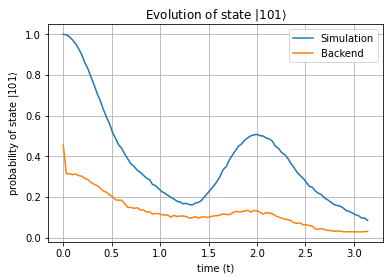

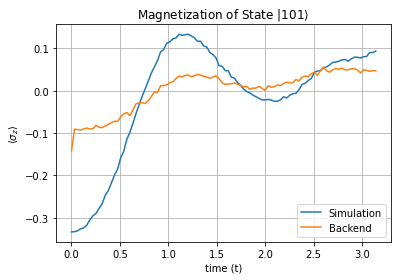

In [23]:
# plot probability of 101 state from job results

count_list = results.get_counts()
probs_backend = {}#initalize dict for probs of each state
for output in ['000','001','010','100','101','110','011','111']:
    probs_backend[output]=[]
    
for counts in count_list:
    
        for output in ['000','001','010','100','101','110','011','111']:
            if output in counts:
                probs_backend[output].append(counts[output]/shots)
            else:
                probs_backend[output].append(0)
            
plt.plot(ts, probs['101'],label='Simulation')
plt.plot(ts, probs_backend['101'],label='Backend')
plt.xlabel('time (t)')
plt.ylabel(r'probability of state $|101\rangle$')
plt.title(r'Evolution of state $|101\rangle$')
plt.legend(loc='upper right')
plt.grid()
plt.show()


#Compute the magnetization at each time step from backend data
magZ_backend = []
for i,t in enumerate(ts):
    magZ_backend.append(sigmaZ(probs_backend,i))
    
plt.plot(ts, magZ,label='Simulation')
plt.plot(ts, magZ_backend,label='Backend')
plt.xlabel('time (t)')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title(r'Magnetization of State $|101\rangle$')
plt.legend(loc='lower right')
plt.grid()
plt.show()